<a href="https://colab.research.google.com/github/Nilanshrajput/Vqa_detr/blob/master/Detr_vilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [12]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 9.2MB/s 
     |████████████████████████████████| 890kB 36.3MB/s 
     |████████████████████████████████| 1.1MB 40.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=dcb84f1a1a703f147dc6d814a071a360ff4a58bd98c05dd1fcd6ee7449ba62f8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import json

import torch
import torch.utils.data as data
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);
import os
import json
import tqdm

import logging

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers.tokenization_bert import BertTokenizer
import torchtext

import pdb

## DETR
Here is a minimal implementation of DETR:

In [0]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP) nj
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        bb_ot = h
        print(h.shape)
        # construct positional encodings
        """        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)"""

        bs,_,H, W = h.shape
        pos = torch.cat([
        self.col_embed[:W].unsqueeze(0).unsqueeze(1).repeat(bs,H, 1, 1),
        self.row_embed[:H].unsqueeze(0).unsqueeze(2).repeat(bs,1, W, 1),
        ], dim=-1).flatten(1, 2)


        #print(self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1))
        # propagate through the transformer
        #shape changed to (W*H,bs,hidden_dim) for both pos and h
        h = self.transformer(pos.permute(1, 0, 2) + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1).repeat(1,bs,1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid(),
                'decoder_out':h,
                'res_out':bb_ot}

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


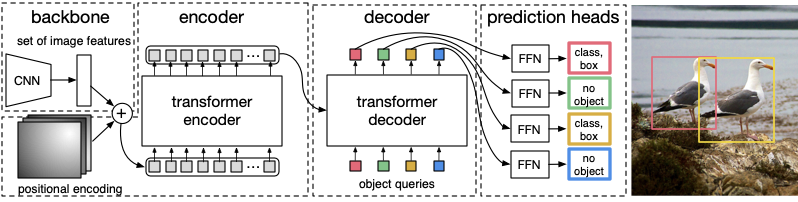

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

In [0]:
class QueryTransformer(nn.Module):
    

In [71]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();


Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/checkpoints/detr_demo-da2a99e9.pth


## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

In [0]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [0]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Let's put everything together in a `detect` function:

In [0]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im)
    img = torch.stack((img,img))
    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled, outputs['decoder_out'],outputs['res_out']

## Using DETR
To try DETRdemo model on your own image just change the URL below.

In [0]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url2='https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/dogs_1280p_0.jpg?itok=cnRk0HYq'
url3=''
im = Image.open(requests.get(url, stream=True).raw)



In [76]:
scores, boxes,attn_out,h = detect(im, detr, transform)

torch.Size([2, 256, 25, 34])


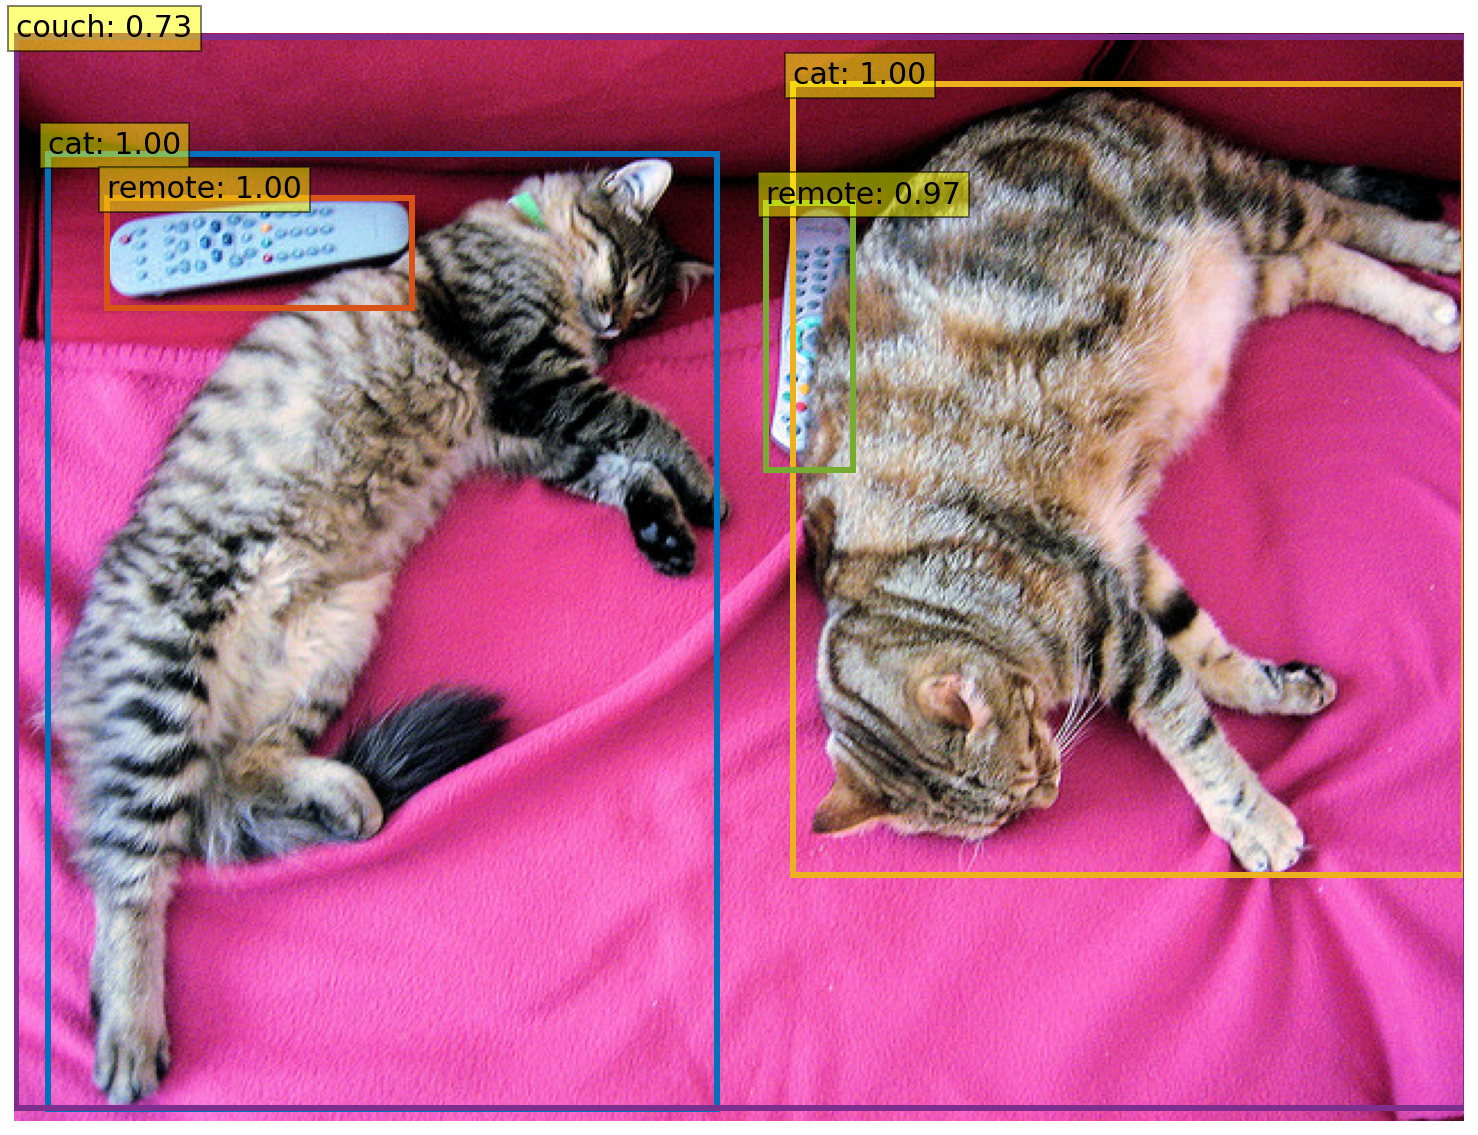

In [77]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

In [79]:
h.shape

torch.Size([2, 256, 25, 34])

In [0]:
nn.Transformer??

In [0]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip" -c -O 'v2_Annotations_Train_mscoco.zip'

In [0]:
!unzip /content/v2_Annotations_Train_mscoco.zip

In [0]:
!wget --header="Host: images.cocodataset.org" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "http://images.cocodataset.org/zips/train2014.zip" -c -O 'train2014.zip'

In [0]:
!unzip train2014.zip

In [0]:
!wget --header="Host: s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip" -c -O 'v2_Questions_Train_mscoco.zip'

In [0]:
!unzip v2_Questions_Train_mscoco.zip

In [0]:

def assert_eq(real, expected):
    assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

def _create_entry(question, answer):
    answer.pop("image_id")
    answer.pop("question_id")
    entry = {
        "question_id": question["question_id"],
        "image_id": question["image_id"],
        "question": question["question"],
        "answer": [a['answer'] for a in answer['answers']],
    }
    return entry

def _load_dataset(dataroot, name):
    """Load entries
    dataroot: root path of dataset
    name: 'train', 'val', 'trainval', 'minsval'
    """
    if name == 'train' or name == 'val':
        question_path = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % name)
        questions = sorted(json.load(open(question_path))["questions"], key=lambda x: x["question_id"])
        answer_path = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % name)
        answers = json.load(open(answer_path, "rb"))["annotations"]
        answers = sorted(answers, key=lambda x: x["question_id"])

    elif name  == 'trainval':
        question_path_train = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'train')
        questions_train = sorted(json.load(open(question_path_train))["questions"], key=lambda x: x["question_id"])
        answer_path_train = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'train')
        answers_train = json.load(open(answer_path_train, "rb"))["annotations"]
        answers_train = sorted(answers_train, key=lambda x: x["question_id"])

        question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
        questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
        answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
        answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
        answers_val = sorted(answers_val, key=lambda x: x["question_id"])
        questions = questions_train + questions_val[:-3000]
        answers = answers_train + answers_val[:-3000]

    elif name == 'minval':
        question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
        questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
        answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
        answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
        answers_val = sorted(answers_val, key=lambda x: x["question_id"])        
        questions = questions_val[-3000:]
        answers = answers_val[-3000:]

    elif name == 'test':
        question_path_test = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2015_questions.json" % 'test')
        questions_test = sorted(json.load(open(question_path_test))["questions"], key=lambda x: x["question_id"])
        questions = questions_test
    else:
        assert False, "data split is not recognized."

    if 'test' in name:
        entries = []
        for question in questions:
            entries.append(question)
    else:
        assert_eq(len(questions), len(answers))
        entries = []
        for question, answer in zip(questions, answers):
            assert_eq(question["question_id"], answer["question_id"])
            assert_eq(question["image_id"], answer["image_id"])
            entries.append(_create_entry(question, answer))
    return entries

In [0]:
entries = _load_dataset(dataroot='/content/',name='train')

In [0]:
# compile a list of all the answers
all_answers  = set()
for a in entries:
    all_answers.update(a['answer'])
all_answers=list(all_answers)


In [0]:
answer_to_index = dict()
for i,answer in enumerate(all_answers):
    answer_to_index[answer]=i


In [0]:
"""expanded_entries = []

# makes entries with single answer only
def single_entry(answer, answer_id,image_id, question, question_id):
    entry = {
        'answer': answer,
        'answer_id': answer_id,
        'image_id': image_id,
        'question': question,
        'question_id': question_id,
    }

    return entry


for entry in tqdm.tqdm(entries):
    for answer in entry['answer']:
        expanded_entries.append(single_entry(answer, answer_to_index.get(answer), entry['image_id'], entry['question'], entry['question_id']))

"""

100%|██████████| 443757/443757 [00:01<00:00, 236735.99it/s]


In [0]:
def _encode_answers(answers, answer_to_index):
    """ Turn an answer into a vector """
    # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
    # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
    # to get the loss that is weighted by how many humans gave that answer
    answer_vec = torch.zeros(len(answer_to_index))
    for answer in answers:
        index = answer_to_index.get(answer)
        if index is not None:
            answer_vec[index] += 1
    return answer_vec

def add_vec_to_entries(entries, answer_to_index):
    for entry in entries:
        entry['answer_vector']= _encode_answers(entry['answer'], answer_to_index)
    return entries
entries = add_vec_to_entries(entries, answer_to_index)

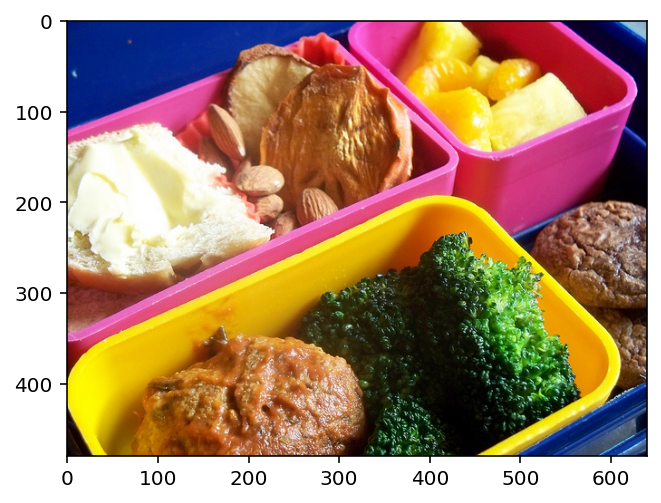

In [21]:
def _find_iamges():
    id_to_filename = {}
    root = 'train2014'
    for filename in os.listdir('train2014'):
        if not filename.endswith('.jpg'):
            continue
        id_and_extension = filename.split('_')[-1]
        id = int(id_and_extension.split('.')[0])
        id_to_filename[id] = os.path.join(root,filename)
    return id_to_filename


id_to_image_fname=_find_iamges()

img_path = id_to_image_fname[9]
img  = Image.open(img_path)
plt.imshow(img)


In [0]:
class VQA(data.Dataset):
    """ VQA dataset, open-ended """
    def __init__(self, root, answer_to_index, tokenizer ,split = 'train', max_len = 20):
        super(VQA, self).__init__()


        self.root = root
        self.answer_to_index = answer_to_index
        self.split = split
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.entries = self._load_dataset( self.root, self.split)

         # standard PyTorch mean-std input image normalization
        self.transform = T.Compose([
            T.Resize(800),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.id_to_image_fname = self._find_iamges()


    def assert_eq(self,real, expected):
        assert real == expected, "%s (true) vs %s (expected)" % (real, expected)

    def _create_entry(self,question, answer):
        answer.pop("image_id")
        answer.pop("question_id")
        entry = {
            "question_id": question["question_id"],
            "image_id": question["image_id"],
            "question": question["question"],
            "answer": [a['answer'] for a in answer['answers']],
        }
        return entry

    def _load_dataset(self,dataroot, name):
        """Load entries
        dataroot: root path of dataset
        name: 'train', 'val', 'trainval', 'minsval'
        """
        if name == 'train' or name == 'val':
            question_path = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % name)
            questions = sorted(json.load(open(question_path))["questions"], key=lambda x: x["question_id"])
            answer_path = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % name)
            answers = json.load(open(answer_path, "rb"))["annotations"]
            answers = sorted(answers, key=lambda x: x["question_id"])

        elif name  == 'trainval':
            question_path_train = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'train')
            questions_train = sorted(json.load(open(question_path_train))["questions"], key=lambda x: x["question_id"])
            answer_path_train = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'train')
            answers_train = json.load(open(answer_path_train, "rb"))["annotations"]
            answers_train = sorted(answers_train, key=lambda x: x["question_id"])

            question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
            questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
            answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
            answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
            answers_val = sorted(answers_val, key=lambda x: x["question_id"])
            questions = questions_train + questions_val[:-3000]
            answers = answers_train + answers_val[:-3000]

        elif name == 'minval':
            question_path_val = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2014_questions.json" % 'val')
            questions_val = sorted(json.load(open(question_path_val))["questions"], key=lambda x: x["question_id"])
            answer_path_val = os.path.join(dataroot, "v2_mscoco_%s2014_annotations.json" % 'val')
            answers_val = json.load(open(answer_path_val, "rb"))["annotations"]
            answers_val = sorted(answers_val, key=lambda x: x["question_id"])        
            questions = questions_val[-3000:]
            answers = answers_val[-3000:]

        elif name == 'test':
            question_path_test = os.path.join(dataroot, "v2_OpenEnded_mscoco_%s2015_questions.json" % 'test')
            questions_test = sorted(json.load(open(question_path_test))["questions"], key=lambda x: x["question_id"])
            questions = questions_test
        else:
            assert False, "data split is not recognized."

        if 'test' in name:
            entries = []
            for question in questions:
                entries.append(question)
        else:
            assert_eq(len(questions), len(answers))
            entries = []
            for question, answer in zip(questions, answers):
                assert_eq(question["question_id"], answer["question_id"])
                assert_eq(question["image_id"], answer["image_id"])
                entries.append(_create_entry(question, answer))
        return entries



    def _encode_question(self, question):
        """ Turn a question into a vector of indices and a question length """
        
        inputs = self.tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        padding_length = self.max_len - len(ids)
        ids += ([0]*padding_length)
        mask += ([0]*padding_length)
        token_type_ids += ([0]*padding_length)
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            
        }

    def _encode_ansfor_bert(self, answers):
        pass


    def _encode_answers(self, answers):
        """ Turn an answer into a vector """
        # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
        # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
        # to get the loss that is weighted by how many humans gave that answer
        answer_vec = torch.zeros(len(self.answer_to_index))
        for answer in answers:
            index = self.answer_to_index.get(answer)
            if index is not None:
                answer_vec[index] += 1
        return answer_vec

   
    def _find_iamges(self):
        id_to_filename = {}
        imgs_folder = os.path.join(self.root,'train2014')
        for filename in os.listdir(imgs_folder):
            if not filename.endswith('.jpg'):
                continue
            id_and_extension = filename.split('_')[-1]
            id = int(id_and_extension.split('.')[0])
            id_to_filename[id] = os.path.join(imgs_folder,filename)
        return id_to_filename


    def _load_image(self, image_id):
        """ Load an image """

        img_path = self.id_to_image_fname[image_id]
        img  = Image.open(img_path)
        
        return img

    def __getitem__(self, item):
       
        entry  = self.entries[item]
        q = entry['question']
        a = self._encode_answers(entry['answer'])
        image_id = entry['image_id']

        img = self._load_image(image_id)
        img = self.transform(img)
        #question_id = entry['question_id']
        q= self._encode_question(q)

        return img, q, a

    def __len__(self):
        return len(self.entries)

In [54]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
vqa_data = VQA(root='/content', answer_to_index=answer_to_index,split= 'train', tokenizer=bert_tokenizer, max_len=15 )

In [0]:
data_loader = DataLoader(vqa_data, batch_size = 16, shuffle= True)

In [0]:
img,q,a=vqa_data[1]

In [88]:
q['ids'].shape

torch.Size([15])

In [0]:
from transformers import BertModel
BertModel??

In [0]:
while 1 :
    continue